In [1]:
from google.colab import drive
drive.mount("/content/drive")

base_folder = 'drive/My Drive/eva_stored_from_colab/eva5/'
acc_recorder_file = "highest_accuracy_achieved"
model_file_name = "added_1x1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
from operator import itemgetter
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 12, 3)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.antman = nn.Conv2d(12, 12, 1)
        self.conv3 = nn.Conv2d(12, 20, 3)
        self.bn3 = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20, 20, 3)
        self.bn4 = nn.BatchNorm2d(20)
        self.conv5 = nn.Conv2d(20, 20, 3)
        self.bn5 = nn.BatchNorm2d(20)
        self.conv6 = nn.Conv2d(20, 10, 6)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.antman(self.pool1(x))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.conv6(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 12, 24, 24]             876
       BatchNorm2d-4           [-1, 12, 24, 24]              24
         MaxPool2d-5           [-1, 12, 12, 12]               0
            Conv2d-6           [-1, 12, 12, 12]             156
            Conv2d-7           [-1, 20, 10, 10]           2,180
       BatchNorm2d-8           [-1, 20, 10, 10]              40
            Conv2d-9             [-1, 20, 8, 8]           3,620
      BatchNorm2d-10             [-1, 20, 8, 8]              40
           Conv2d-11             [-1, 20, 6, 6]           3,620
      BatchNorm2d-12             [-1, 20, 6, 6]              40
           Conv2d-13             [-1, 10, 1, 1]           7,210
Total params: 17,902
Trainable params: 

In [5]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    
    total_imgs = len(train_loader.dataset)
    train_loss /= total_imgs
    accuracy = 100. * correct / total_imgs

    print('\nTrain Data: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        train_loss, correct, total_imgs, accuracy)
    )
    
    return train_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

def record_max_acc(max_acc):
    f = open(base_folder+acc_recorder_file, "w")
    f.write(str(max_acc))
    f.close()

In [7]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start = time.time()
test_acc = []
train_acc = []

try:
    with open(base_folder+acc_recorder_file, "r") as infl:
        max_acc = float(infl.read().strip())
except:
    max_acc = 0.0

print("\nLAST RECORDED MAX ACCURACY: ", max_acc)
for epoch in range(1, 21):
    ep_start = time.time()
    print()
    print("EPOCH NUM {}".format(epoch))
    trl, tra = train(model, device, train_loader, optimizer, epoch)
    tsl, tsa = test(model, device, test_loader)
    test_acc.append(tsa)
    train_acc.append(tra)
    if tsa > max_acc:
        max_acc = tsa
        torch.save(model.state_dict(), base_folder+model_file_name+"_sd.pth")
        record_max_acc(max_acc)
    print("-----------------------------------------------")
print("TOTAL TRAINING TIME: ", time.time() - start)
print("LAST 10 EPOCH AVG ACC: ", sum(test_acc[-10:]) / len(test_acc[-10:]) )
print("LAST 5 EPOCH AVG ACC: ", sum(test_acc[-5:]) / len(test_acc[-5:]) )
print("MAX ACCURACY: ", max(test_acc))

  0%|          | 0/469 [00:00<?, ?it/s]


LAST RECORDED MAX ACCURACY:  0.9939

EPOCH NUM 1


loss=0.06467557698488235 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]


Train Data: Average loss: 0.0010, Accuracy: 57719/60000 (96.1983%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9880/10000 (98.8000%)

-----------------------------------------------

EPOCH NUM 2


loss=0.03472624346613884 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]


Train Data: Average loss: 0.0003, Accuracy: 59278/60000 (98.7967%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9899/10000 (98.9900%)

-----------------------------------------------

EPOCH NUM 3


loss=0.01899717189371586 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]


Train Data: Average loss: 0.0002, Accuracy: 59451/60000 (99.0850%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.2200%)

-----------------------------------------------

EPOCH NUM 4


loss=0.016162041574716568 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.35it/s]


Train Data: Average loss: 0.0002, Accuracy: 59566/60000 (99.2767%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.0600%)

-----------------------------------------------

EPOCH NUM 5


loss=0.044961750507354736 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]


Train Data: Average loss: 0.0002, Accuracy: 59656/60000 (99.4267%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.2500%)

-----------------------------------------------

EPOCH NUM 6


loss=0.07830803841352463 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]


Train Data: Average loss: 0.0001, Accuracy: 59727/60000 (99.5450%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.1800%)

-----------------------------------------------

EPOCH NUM 7


loss=0.0041682845912873745 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s]


Train Data: Average loss: 0.0001, Accuracy: 59777/60000 (99.6283%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.2700%)

-----------------------------------------------

EPOCH NUM 8


loss=0.02607846073806286 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]


Train Data: Average loss: 0.0001, Accuracy: 59822/60000 (99.7033%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9924/10000 (99.2400%)

-----------------------------------------------

EPOCH NUM 9


loss=0.005151798017323017 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.61it/s]


Train Data: Average loss: 0.0001, Accuracy: 59840/60000 (99.7333%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.2400%)

-----------------------------------------------

EPOCH NUM 10


loss=0.0017276513390243053 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s]


Train Data: Average loss: 0.0001, Accuracy: 59876/60000 (99.7933%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.3300%)

-----------------------------------------------

EPOCH NUM 11


loss=0.01066654548048973 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.88it/s]


Train Data: Average loss: 0.0001, Accuracy: 59905/60000 (99.8417%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9925/10000 (99.2500%)

-----------------------------------------------

EPOCH NUM 12


loss=0.00046403121086768806 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.64it/s]


Train Data: Average loss: 0.0000, Accuracy: 59922/60000 (99.8700%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.2600%)

-----------------------------------------------

EPOCH NUM 13


loss=0.0002689478569664061 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.08it/s]


Train Data: Average loss: 0.0000, Accuracy: 59961/60000 (99.9350%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.2800%)

-----------------------------------------------

EPOCH NUM 14


loss=0.0012940011220052838 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]


Train Data: Average loss: 0.0000, Accuracy: 59972/60000 (99.9533%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.2800%)

-----------------------------------------------

EPOCH NUM 15


loss=0.0001315215922659263 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]


Train Data: Average loss: 0.0000, Accuracy: 59976/60000 (99.9600%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.3400%)

-----------------------------------------------

EPOCH NUM 16


loss=0.0007236716919578612 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.65it/s]


Train Data: Average loss: 0.0000, Accuracy: 59979/60000 (99.9650%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.2600%)

-----------------------------------------------

EPOCH NUM 17


loss=0.0027088767383247614 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.10it/s]


Train Data: Average loss: 0.0000, Accuracy: 59988/60000 (99.9800%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.3700%)

-----------------------------------------------

EPOCH NUM 18


loss=0.0007491912692785263 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.46it/s]


Train Data: Average loss: 0.0000, Accuracy: 59998/60000 (99.9967%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9941/10000 (99.4100%)

-----------------------------------------------

EPOCH NUM 19


loss=0.0008662620093673468 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]


Train Data: Average loss: 0.0000, Accuracy: 59998/60000 (99.9967%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.4200%)

-----------------------------------------------

EPOCH NUM 20


loss=0.00036309854476712644 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.77it/s]


Train Data: Average loss: 0.0000, Accuracy: 59999/60000 (99.9983%)




Test set: Average loss: 0.0221, Accuracy: 9940/10000 (99.4000%)

-----------------------------------------------
TOTAL TRAINING TIME:  292.12875175476074
LAST 10 EPOCH AVG ACC:  0.9932699999999999
LAST 5 EPOCH AVG ACC:  0.9937199999999999
MAX ACCURACY:  0.9942


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[96.19833333333334, 98.79666666666667, 99.085, 99.27666666666667, 99.42666666666666, 99.545, 99.62833333333333, 99.70333333333333, 99.73333333333333, 99.79333333333334, 99.84166666666667, 99.87, 99.935, 99.95333333333333, 99.96, 99.965, 99.98, 99.99666666666667, 99.99666666666667, 99.99833333333333]
[98.8, 98.99, 99.22, 99.06, 99.25, 99.18, 99.27, 99.24, 99.24, 99.33, 99.25, 99.26, 99.28, 99.28, 99.33999999999997, 99.26, 99.37, 99.41, 99.42, 99.4]


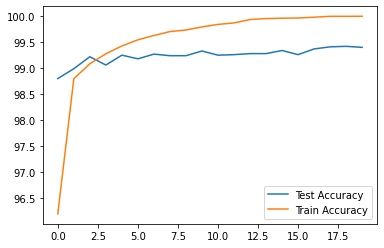

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis = list(range(len(test_acc)))
new_test_acc = [x/100.0 for x in test_acc]

plt.plot(xaxis, new_test_acc, label="Test Accuracy")
plt.plot(xaxis, train_acc, label="Train Accuracy")
plt.legend()
plt.show()